In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB7

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

In [2]:
# Load and preprocess the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/FracAtlas/images/',
    label_mode='binary',
    seed=123,
    validation_split=0.2,
    subset="both",
    image_size=(600, 600),
    batch_size=16
)

Found 3996 files belonging to 2 classes.
Using 3197 files for training.
Using 799 files for validation.


In [3]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [6]:
inputs = layers.Input(shape=(600, 600, 3))
model = EfficientNetB7(include_top=False, input_tensor=inputs, weights='imagenet')
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy", 'AUC', 'Precision', 'Recall']
)

In [7]:
epochs = 25
hist = model.fit(dataset[0], epochs=epochs, validation_data=dataset[1])

Epoch 1/25
200/200 [==============================] - 223s 995ms/step - loss: 0.9310 - accuracy: 0.8164 - auc: 0.7523 - precision: 0.8891 - recall: 0.8868 - val_loss: 1.1377 - val_accuracy: 0.8223 - val_auc: 0.6520 - val_precision: 0.8221 - val_recall: 1.0000
Epoch 2/25
200/200 [==============================] - 198s 990ms/step - loss: 0.8832 - accuracy: 0.8383 - auc: 0.7992 - precision: 0.8989 - recall: 0.9047 - val_loss: 0.9716 - val_accuracy: 0.8586 - val_auc: 0.7601 - val_precision: 0.8625 - val_recall: 0.9848
Epoch 3/25
200/200 [==============================] - 200s 996ms/step - loss: 0.7734 - accuracy: 0.8511 - auc: 0.8164 - precision: 0.9068 - recall: 0.9123 - val_loss: 0.7615 - val_accuracy: 0.8673 - val_auc: 0.8098 - val_precision: 0.8873 - val_recall: 0.9604
Epoch 4/25
200/200 [==============================] - 200s 1s/step - loss: 0.7152 - accuracy: 0.8536 - auc: 0.8225 - precision: 0.9071 - recall: 0.9154 - val_loss: 0.6572 - val_accuracy: 0.8536 - val_auc: 0.8316 - val_pr

50/50 [==============================] - 42s 747ms/step
              precision    recall  f1-score   support

         0.0       0.84      0.36      0.51       143
         1.0       0.88      0.98      0.93       656

    accuracy                           0.87       799
   macro avg       0.86      0.67      0.72       799
weighted avg       0.87      0.87      0.85       799

Confusion Matrix:


<Axes: >

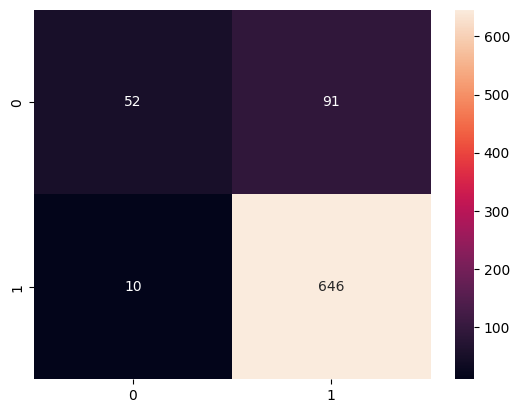

In [8]:
# Get the predictions on the validation data
y_pred = model.predict(dataset[1])

# Convert the predictions to binary values
y_pred_binary = (y_pred > 0.5).astype(int)

# Get the true labels from the validation data
y_true = np.concatenate([y for x, y in dataset[1]], axis=0)

# Generate the classification report
report = classification_report(y_true, y_pred_binary)
print(report)

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_true,y_pred_binary),annot = True,fmt='d')

In [11]:
model.save_weights('efficientnetb7.h5')